# 常用的语音特征之FBank和MFCC（原理 + Python实现）

### 1. 导包

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

### 2. 绘图工具

In [2]:
# 绘制时域图
def plot_time(signal, sample_rate):
    time = np.arange(0, len(signal)) * (1.0 / sample_rate)
    plt.figure(figsize=(20, 5))
    plt.plot(time, signal)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')
    plt.grid()

In [3]:
# 绘制频域图
def plot_freq(signal, sample_rate, fft_size=512):
    xf = np.fft.rfft(signal, fft_size) / fft_size
    freqs = np.linspace(0, sample_rate/2, fft_size/2 + 1)
    xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))
    plt.figure(figsize=(20, 5))
    plt.plot(freqs, xfp)
    plt.xlabel('Freq(hz)')
    plt.ylabel('dB')
    plt.grid()

In [4]:
# 绘制频谱图
def plot_spectrogram(spec, note):
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(note)
    plt.tight_layout()

### 3. 数据准备

In [5]:
sample_rate, signal = wavfile.read('./resources/aa.wav')
print('sample rate:', sample_rate, ', frame length:', len(signal))

sample rate: 8000 , frame length: 17520


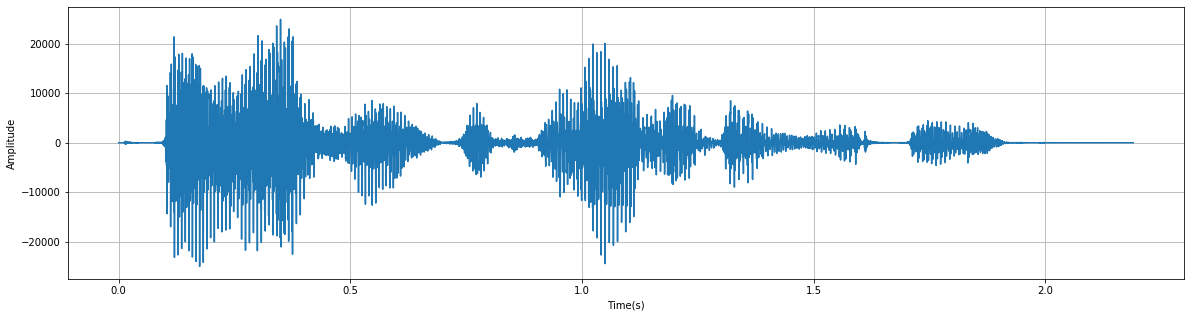

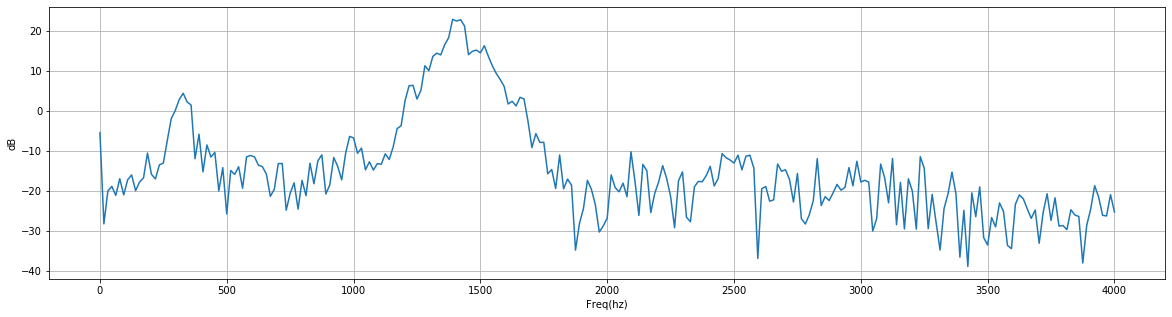

In [29]:
plot_time(signal, sample_rate)
plot_freq(signal, sample_rate)

In [26]:
def normalize_data(signal):
    max_val = max(np.abs(signal))
    
    if max_val == 0:
        return signal
    
    return signal/max_val
        
emphasized_signal = normalize_data(signal)
plot_time(emphasized_signal, sample_rate)

## 预加重（Pre-Emphasis）

预加重一般是数字语音信号处理的第一步。语音信号往往会有频谱倾斜（Spectral Tilt）现象，即高频部分的幅度会比低频部分的小，预加重在这里就是起到一个平衡频谱的作用，增大高频部分的幅度。它使用如下的一阶滤波器来实现：

$$y(t) = x(t) - \alpha x(t-1), \ \ \ \  0.95 < \alpha < 0.99$$

信号频率的高低主要是由信号电平变化的速度所决定，对信号做一阶差分时，高频部分（变化快的地方）差分值大，低频部分（变化慢的地方）差分值小，达到平衡频谱的作用。

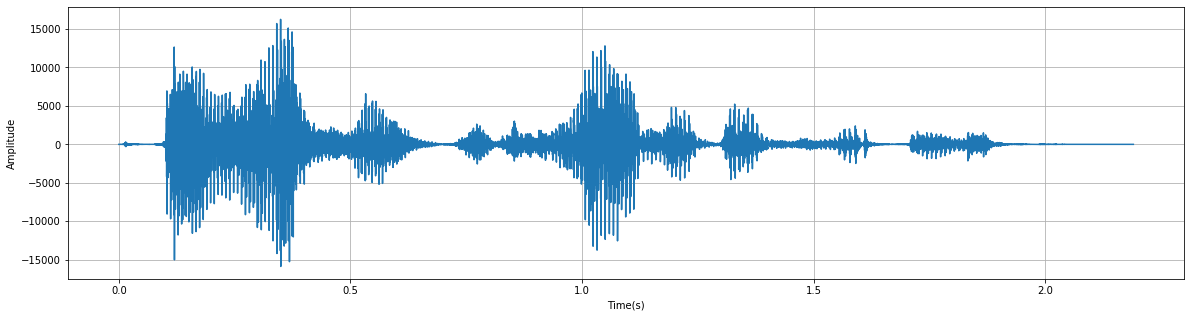

In [27]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plot_time(emphasized_signal, sample_rate)

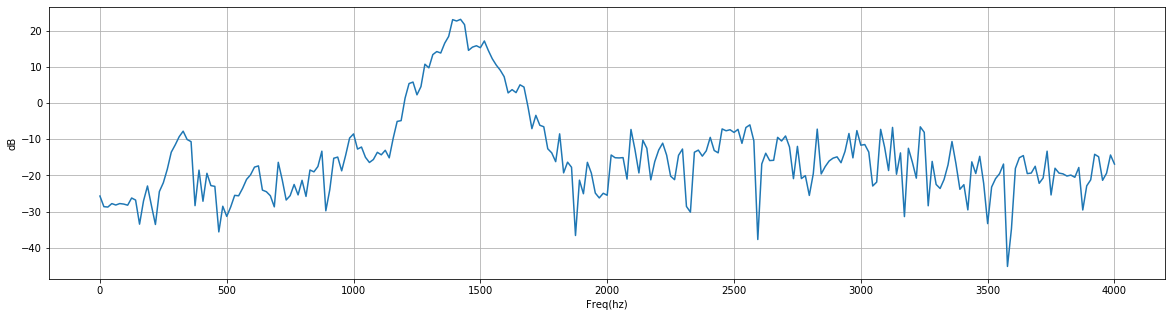

In [9]:
plot_freq(emphasized_signal, sample_rate)

从下面这个图来看，确实起到了平衡频谱的作用。

## 分帧（Framing）

在预加重之后，需要将信号分成短时帧。做这一步的原因是：信号中的频率会随时间变化（不稳定的），一些信号处理算法（比如傅里叶变换）通常希望信号是稳定，也就是说对整个信号进行处理是没有意义的，因为信号的频率轮廓会随着时间的推移而丢失。为了避免这种情况，需要对信号进行分帧处理，认为每一帧之内的信号是短时不变的。一般设置帧长取20ms~40ms，相邻帧之间50%（+/-10%）的覆盖。通常取帧长为25ms，覆盖为10ms。

In [10]:
frame_size, frame_stride = 0.025, 0.01
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))

num_frames = int(np.ceil(np.abs(len(emphasized_signal) - frame_length) / frame_step))
new_len = (num_frames-1) * frame_step + frame_length
new_signal = emphasized_signal[:new_len]

indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
frames = new_signal[indices]
print(frames.shape)

(217, 200)


## 加窗（Window）

在分帧之后，通常需要对每帧的信号进行加窗处理。目的是让帧两端平滑地衰减，这样可以降低后续傅里叶变换后旁瓣的强度，取得更高质量的频谱。常用的窗有：矩形窗、汉明（Hamming）窗、汉宁窗（Hanning），以汉明窗为例，其窗函数为：

$$w(n) = 0.54 - 0.46 cos(\frac{2\pi n}{N-1})$$

这里的$0<=n<=N-1$，$N$是窗的宽度。

In [11]:
hamming = np.hamming(frame_length)
# hamming = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(0, frame_length) / (frame_length - 1))

Text(0, 0.5, 'Amplitude')

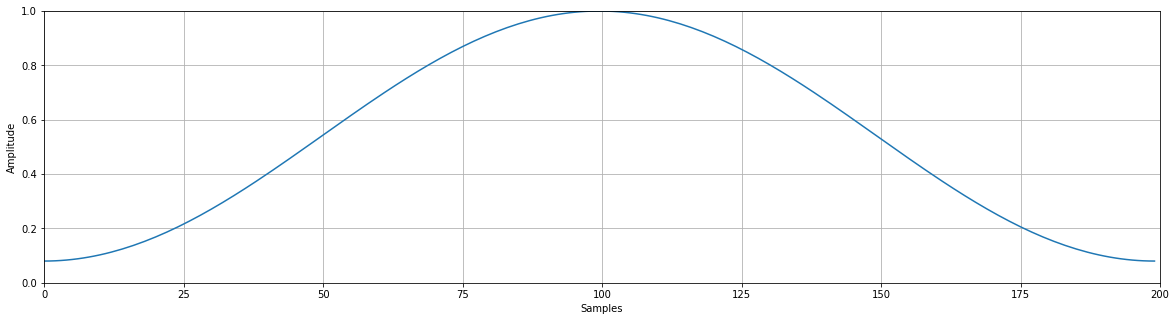

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(hamming)
plt.grid()
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.xlabel('Samples')
plt.ylabel('Amplitude')

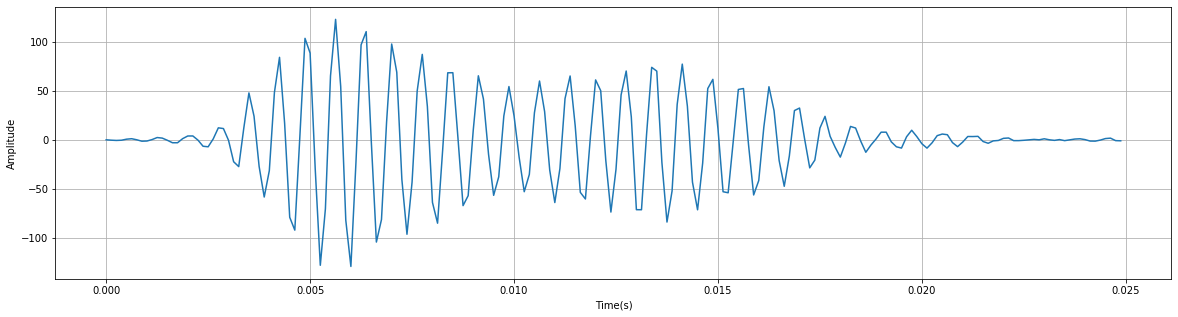

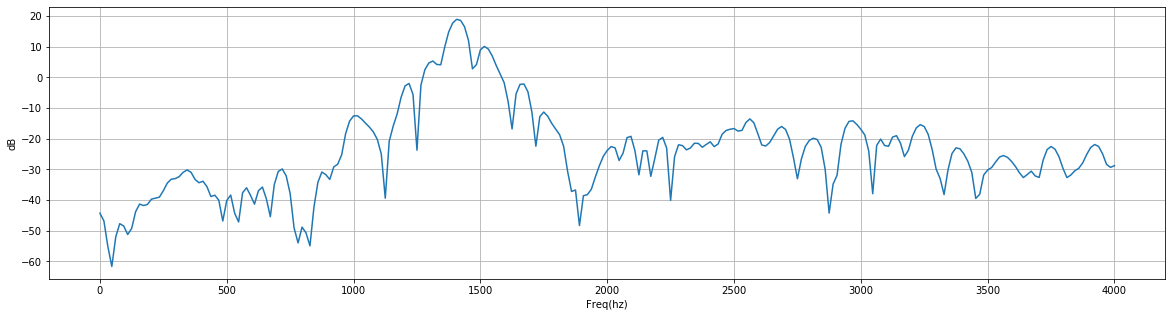

In [13]:
frames *= hamming
plot_time(frames[1], sample_rate)
plot_freq(frames[1], sample_rate)

## 快速傅里叶变换（FFT）

对于每一帧的加窗信号，进行N点FFT变换，也称短时傅里叶变换（STFT），N通常取256或512，然后用如下的公式计算能量谱：

$$ P = \frac{|FFT(x_i)|^2}{N}$$

In [14]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))
print(pow_frames.shape)

(217, 257)


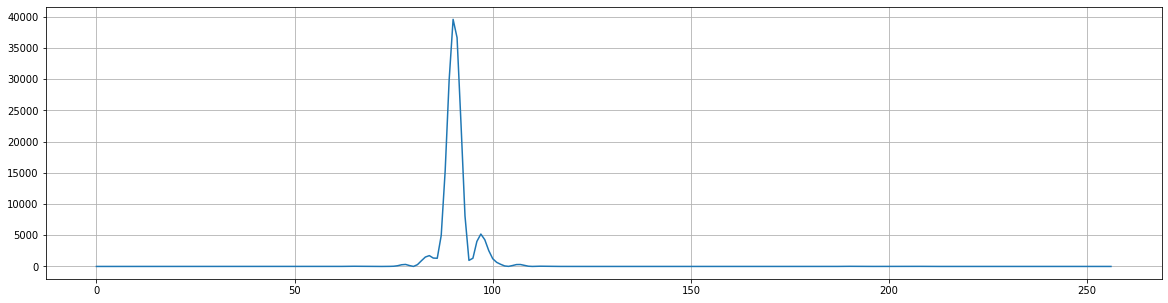

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(pow_frames[1])
plt.grid()

## FBank特征（Filter Banks）

经过上面的步骤之后，在能量谱上应用Mel滤波器组，就能提取到FBank特征。

在介绍Mel滤波器组之前，先介绍一下Mel刻度，这是一个能模拟人耳接收声音规律的刻度，人耳在接收声音时呈现非线性状态，对高频的更不敏感，因此Mel刻度在低频区分辨度较高，在高频区分辨度较低，与频率之间的换算关系为：

$$m = 2595 log_{10} (1 + \frac{f}{700})$$

$$f = 700(10^{m/2595} - 1)$$

Mel滤波器组就是一系列的三角形滤波器，通常有40个或80个，在中心频率点响应值为1，在两边的滤波器中心点衰减到0，如下图：

<img src='./resources/mel_filters.jpg' width='80%'>

具体公式可以写为：

$$
H_m(k) =
  \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m + 1) \\
  \end{cases}
$$

最后在能量谱上应用Mel滤波器组，其公式为：

$$Y_t(m) = \sum_{k=1}^{N} H_m(k)|X_t(k)|^2 $$

其中，k表示FFT变换后的编号，m表示mel滤波器的编号。

In [31]:
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
print(low_freq_mel, high_freq_mel)

nfilt = 40 #mel滤波器的个数

# 所有的mel中心点，为了方便后面计算mel滤波器组，左右两边各补一个中心点
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 将梅尔刻度等间隔
# print(mel_points)

# 由于每个带通滤波器的传递函数值是在Mel频率域上计算的，计算完后需要再转到频率域上
hz_points = 700 * (10 ** (mel_points / 2595) - 1) #把 Mel 变成 Hz
print(hz_points)

0 2146.06452750619
[   0.           33.27818895   68.13843198  104.65594038  142.90950098
  182.98164618  224.95883198  268.93162452  314.99489549  363.2480268
  413.79512499  466.74524587  522.2126298   580.31694812  641.18356143
  704.94378996  771.73519696  841.70188548  914.99480927  991.77209843
 1072.19940064 1156.45023851 1244.70638395 1337.15825037 1434.00530347
 1535.45649162 1641.73069664 1753.05720605 1869.67620777 1991.83930831
 2119.81007563 2253.86460776 2394.29212854 2541.39561156 2695.49243387
 2856.91506071 3026.01176279 3203.14736774 3388.70404717 3583.08214122
 3786.70102232 4000.        ]


257
[  0.           2.12980409   4.36085965   6.69798018   9.14620806
  11.71082536  14.39736525  17.21162397  20.15967331  23.24787371
  26.482888    29.87169574  33.42160831  37.14028468  41.03574793
  45.11640256  49.39105261  53.86892067  58.55966779  63.4734143
  68.62076164  74.01281526  79.66120857  85.57812802  91.77633942
  98.26921546 105.07076459 112.19566119 119.6592773  127.47771573
 135.66784484 144.2473349  153.23469623 162.64931914 172.51151577
 182.84256389 193.66475282 205.00143154 216.87705902 229.31725704
 242.34886543 256.        ]


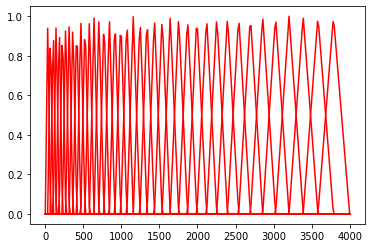

In [33]:
freqs = np.linspace(0, sample_rate/2, NFFT/2 + 1)
print(len(freqs))

fbank = np.zeros((nfilt, int(NFFT / 2 + 1)))  # 各个mel滤波器在能量谱对应点的取值 (217, 257)

bin = (hz_points / (sample_rate / 2)) * (NFFT / 2)  # 各个mel滤波器中心点对应FFT的区域编码，找到有值的位置
print(bin)

for i in range(1, nfilt + 1):
    left = int(bin[i-1])
    center = int(bin[i])
    right = int(bin[i+1])
    for j in range(left, center):
        fbank[i-1, j+1] = (j + 1 - bin[i-1]) / (bin[i] - bin[i-1])

    for j in range(center, right):
        fbank[i-1, j+1] = (bin[i+1] - (j + 1)) / (bin[i+1] - bin[i])

    plt.plot(freqs,fbank[i-1,:],'r')
plt.show()

In [18]:
filter_banks = np.dot(pow_frames, fbank.T) #(217, 257) * (40, 257).T = (217, 40)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB
print(filter_banks.shape)

(217, 40)


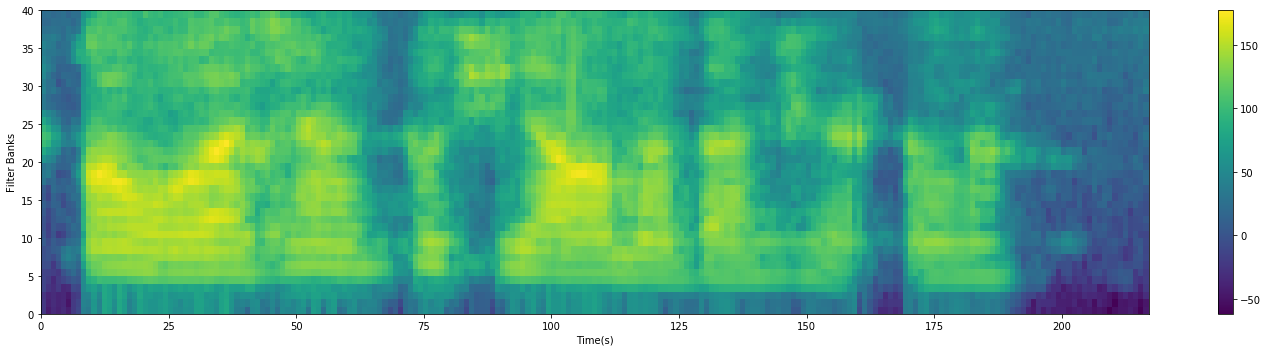

In [19]:
plot_spectrogram(filter_banks.T, 'Filter Banks')

PS：“log mel-filter bank outputs”和“FBANK features”说的是同一个东西。

## MFCC特征（Mel-frequency Cepstral Coefficients）

前面提取到的FBank特征，往往是高度相关的。因此可以继续用DCT变换，将这些相关的滤波器组系数进行压缩。对于ASR来说，通常取2~13维，扔掉的信息里面包含滤波器组系数快速变化部分，这些细节信息在ASR任务上可能没有帮助。

DCT变换其实是逆傅里叶变换的等价替代：

$$y_t(n) = \sum_{m=0}^{M-1}log(Y_t(m))cos(n(m + 0.5) \frac{\pi}{M}), \ \ \ \ \ n = 0, ..., J$$

所以MFCC名字里面有倒谱（Cepstral）。

In [20]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps+1)]
print(mfcc.shape)

(217, 12)


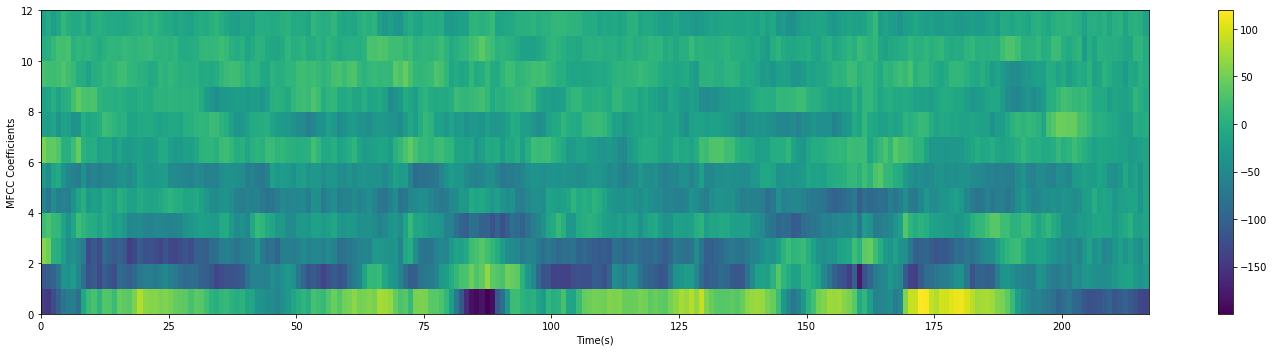

In [21]:
plot_spectrogram(mfcc.T, 'MFCC Coefficients')

## FBank与MFCC比较

FBank特征的提取更多的是希望符合声音信号的本质，拟合人耳接收的特性。而MFCC特征多的那一步则是受限于一些机器学习算法。很早之前MFCC特征和GMMs-HMMs方法结合是ASR的主流。而当一些深度学习方法出来之后，MFCC则不一定是最优选择，因为神经网络对高度相关的信息不敏感，而且DCT变换是线性的，会丢失语音信号中原本的一些非线性成分。

还有一些说法是在质疑傅里叶变换的使用，因为傅里叶变换也是线性的。因此也有很多方法，设计模型直接从原始的音频信号中提取特征，但这种方法会增加模型的复杂度，而且本身傅里叶变换不太容易拟合。同时傅里叶变换是在短时上应用的，可以建设信号在这个短的时间内是静止的，因此傅里叶变换的线性也不会造成很严重的问题。

结论就是：在模型对高相关的信号不敏感时（比如神经网络），可以用FBank特征；在模型对高相关的信号敏感时（比如GMMs-HMMs），需要用MFCC特征。从目前的趋势来看，因为神经网络的逐步发展，FBank特征越来越流行。